In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import feature
from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, accuracy_score, precision_score, recall_score, f1_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("crowww/a-large-scale-fish-dataset")

print("Path to dataset files:", path)

100%|██████████| 3.24G/3.24G [00:45<00:00, 76.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/crowww/a-large-scale-fish-dataset/versions/2


In [4]:
# Main dataset directory
base_dir = os.path.join(path, "Fish_Dataset", "Fish_Dataset")

X = []  # images
y = []  # labels

# Loop through each fish species
for species in os.listdir(base_dir):
    species_path = os.path.join(base_dir, species)
    if not os.path.isdir(species_path):
        continue

    # Loop inside each fish species folder
    for subfolder in os.listdir(species_path):
        subfolder_path = os.path.join(species_path, subfolder)

        # Skip mask folders (GT = Ground Truth)
        if "GT" in subfolder or not os.path.isdir(subfolder_path):
            continue

        # Read image files
        for img_file in os.listdir(subfolder_path):
            if img_file.lower().endswith((".jpg", ".jpeg", ".png")):
                img_path = os.path.join(subfolder_path, img_file)

                # Read and preprocess
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (128, 128))  # resize to standard shape

                X.append(img)
                y.append(species)

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)


print("Total images:", len(X))
print("Classes:", np.unique(y))
print("Image shape:", X[0].shape)


Total images: 9000
Classes: ['Black Sea Sprat' 'Gilt-Head Bream' 'Hourse Mackerel' 'Red Mullet'
 'Red Sea Bream' 'Sea Bass' 'Shrimp' 'Striped Red Mullet' 'Trout']
Image shape: (128, 128, 3)


In [5]:
def bar_chart_cv(values, metric_name, model_name):

    folds = np.arange(1, len(values) + 1)
    mean_val = np.mean(values)

    plt.figure(figsize=(8, 5))

    bars = plt.bar(folds, values, color='skyblue')

    # Add value labels above bars
    for i, v in enumerate(values):
        plt.text(i + 1, v + 0.01, f"{v:.4f}", ha='center')

    # Mean line
    plt.axhline(mean_val, color='red', linestyle='--', linewidth=2,
                label=f"Mean {metric_name} ({mean_val:.4f})")

    # Y-axis settings
    plt.ylim(0, 1.0)
    plt.yticks(np.arange(0, 1.01, 0.20))


    plt.title(f"{metric_name} per Fold - {model_name}")
    plt.xlabel("Fold Number")
    plt.ylabel(metric_name)

    plt.legend(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()


In [6]:
def print_cv_summary(acc_scores, prec_scores, rec_scores, f1_scores, model_name):

    print(f"\n===== Cross-Validation Summary (Macro Averaged) — {model_name} =====")
    print(f"Mean Accuracy : {np.mean(acc_scores):.4f}")
    print(f"Mean Precision: {np.mean(prec_scores):.4f}")
    print(f"Mean Recall   : {np.mean(rec_scores):.4f}")
    print(f"Mean F1-score : {np.mean(f1_scores):.4f}")


## HuMoments Feature Extraction

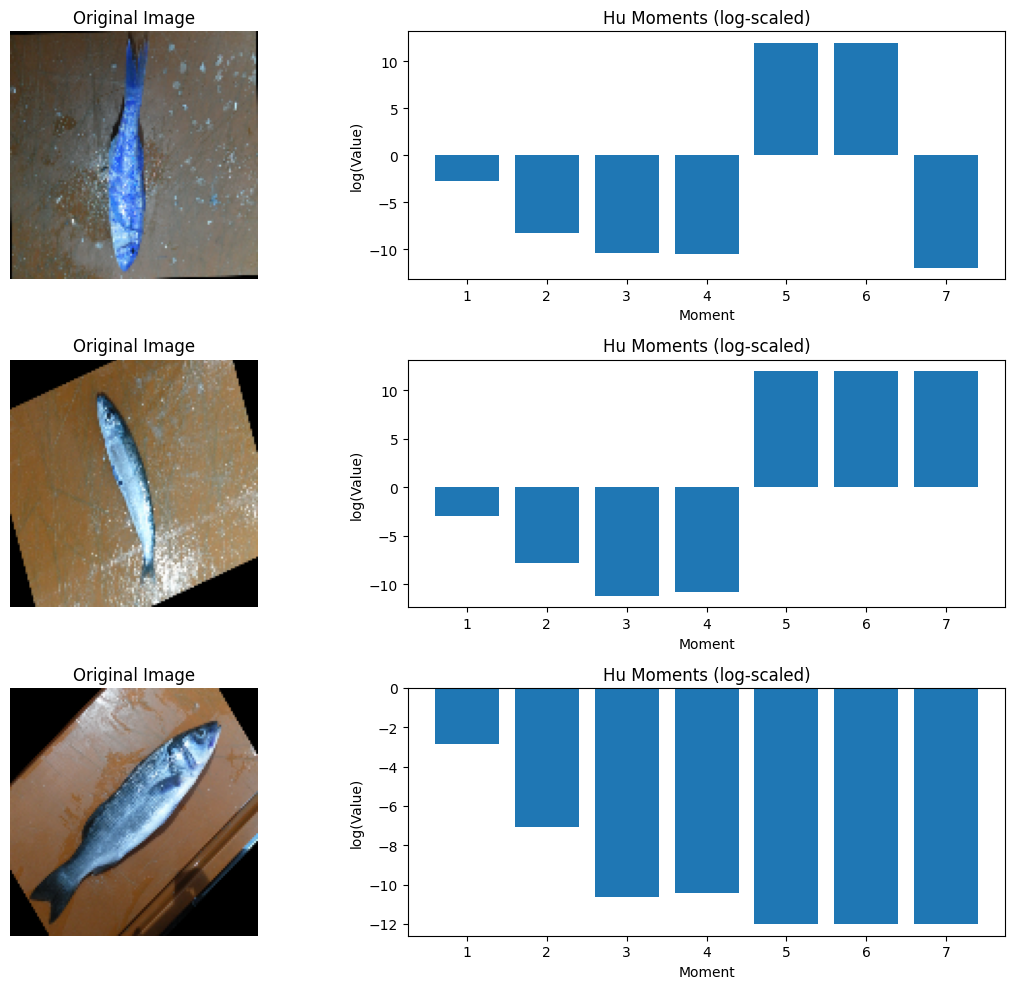

In [7]:
# List to store Hu features
X_hu = []
hu_img = []
for img in X:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    m = cv2.moments(gray)
    hu = cv2.HuMoments(m).flatten()
    hu_img.append(hu)
    X_hu.append(hu.astype(np.float32))

# Convert to NumPy array
X_hu = np.array(X_hu)

# Select 3 images to visualize
indices = [4070, 2287, 6432]
fig, axs = plt.subplots(3, 2, figsize=(12, 10))

for i, idx in enumerate(indices):
    img = X[idx]
    hu = X_hu[idx]
# Log-scale transformation (signed log10)
    hu_log = np.sign(hu) * np.log10(np.abs(hu) + 1e-12)  # avoid log(0)

    # Original image
    axs[i, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[i, 0].set_title("Original Image")
    axs[i, 0].axis('off')

    # Bar plot for log-scaled Hu Moments
    axs[i, 1].bar(range(1, 8), hu_log)
    axs[i, 1].set_title("Hu Moments (log-scaled)")
    axs[i, 1].set_xlabel("Moment")
    axs[i, 1].set_ylabel("log(Value)")

plt.tight_layout()
plt.show()




In [8]:
# Split data
X_train_hu, X_test_hu, y_train, y_test = train_test_split(
    X_hu, y, test_size=0.2, random_state=42
)

# Encode string labels to integers
le = LabelEncoder().fit(y_train)
n_classes = len(le.classes_)
y_train_cat = to_categorical(le.transform(y_train), num_classes=n_classes)
y_test_cat  = to_categorical(le.transform(y_test),  num_classes=n_classes)

# Scale features
scaler = StandardScaler(with_mean=False)
X_train_hu = scaler.fit_transform(X_train_hu)
X_test_hu  = scaler.transform(X_test_hu)

## ANN with moments HU

In [9]:
def build_ann_hu(input_dim, num_classes=9):
    model = Sequential([
        Input(shape=(input_dim,)),
        BatchNormalization(),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


print("\n===== 5-Fold Cross Validation — ANN + HU Moments =====")

num_classes = y_train_cat.shape[1]
y_labels_train = np.argmax(y_train_cat, axis=1)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

acc_scores = []
prec_scores = []
rec_scores = []
f1_scores = []

# track best fold
best_fold = None
best_val_acc = -np.inf
best_history = None
best_model = None
best_y_val = None
best_y_val_pred = None

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_hu, y_labels_train), start=1):
    X_tr, X_val = X_train_hu[train_idx], X_train_hu[val_idx]
    y_tr, y_val = y_labels_train[train_idx], y_labels_train[val_idx]

    y_tr_cat = to_categorical(y_tr, num_classes=num_classes)
    y_val_cat = to_categorical(y_val, num_classes=num_classes)

    model_cv = build_ann_hu(input_dim=X_train_hu.shape[1], num_classes=num_classes)

    # save training history for this fold
    history = model_cv.fit(
        X_tr, y_tr_cat,
        validation_data=(X_val, y_val_cat),
        epochs=300,
        batch_size=64,
        verbose=0
    )

    y_val_pred = np.argmax(model_cv.predict(X_val), axis=1)

    acc = accuracy_score(y_val, y_val_pred)
    prec = precision_score(y_val, y_val_pred, average='macro')
    rec = recall_score(y_val, y_val_pred, average='macro')
    f1 = f1_score(y_val, y_val_pred, average='macro')

    acc_scores.append(acc)
    prec_scores.append(prec)
    rec_scores.append(rec)
    f1_scores.append(f1)

    print(f"\n--- Fold {fold} ---")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")

    # best fold
    if acc > best_val_acc:
        best_val_acc = acc
        best_fold = fold
        best_history = history
        best_model = model_cv
        best_y_val = y_val
        best_y_val_pred = y_val_pred



===== 5-Fold Cross Validation — ANN + HU Moments =====
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

--- Fold 1 ---
Accuracy : 0.6299
Precision: 0.6360
Recall   : 0.6307
F1-score : 0.6234
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

--- Fold 2 ---
Accuracy : 0.6125
Precision: 0.6134
Recall   : 0.6136
F1-score : 0.6101
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

--- Fold 3 ---
Accuracy : 0.6326
Precision: 0.6438
Recall   : 0.6329
F1-score : 0.6335
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

--- Fold 4 ---
Accuracy : 0.6361
Precision: 0.6391
Recall   : 0.6364
F1-score : 0.6359
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

--- Fold 5 ---
Accuracy : 0.6333
Precision: 0.6401
Recall   : 0.6339
F1-score : 0.6269


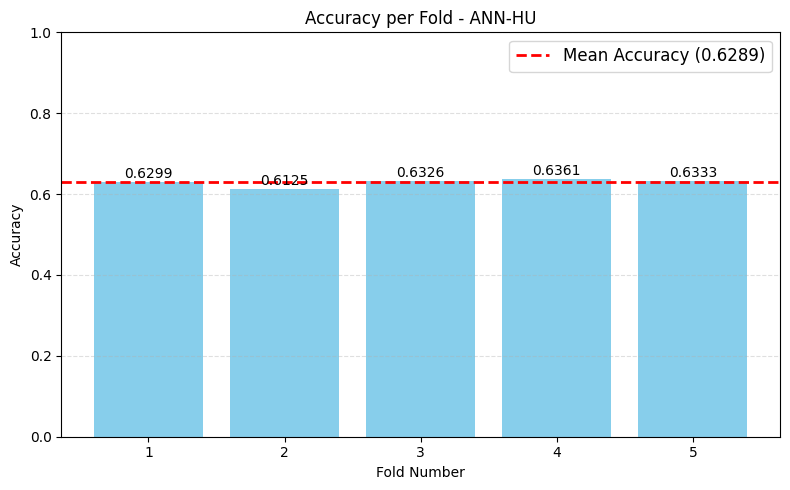

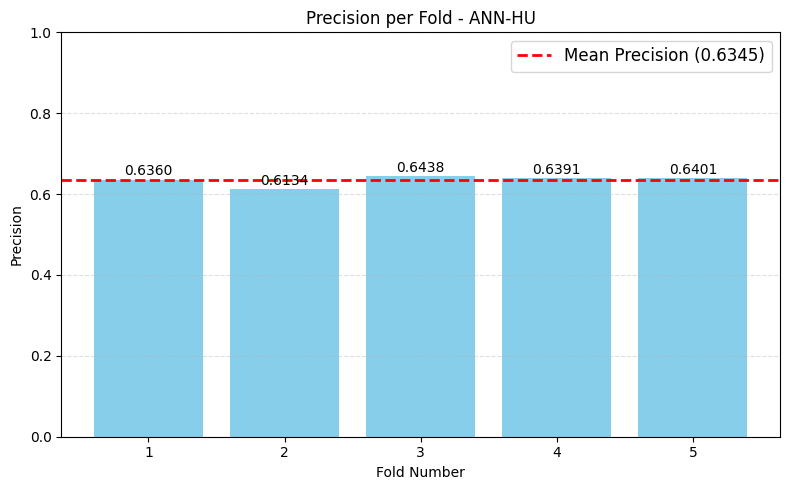

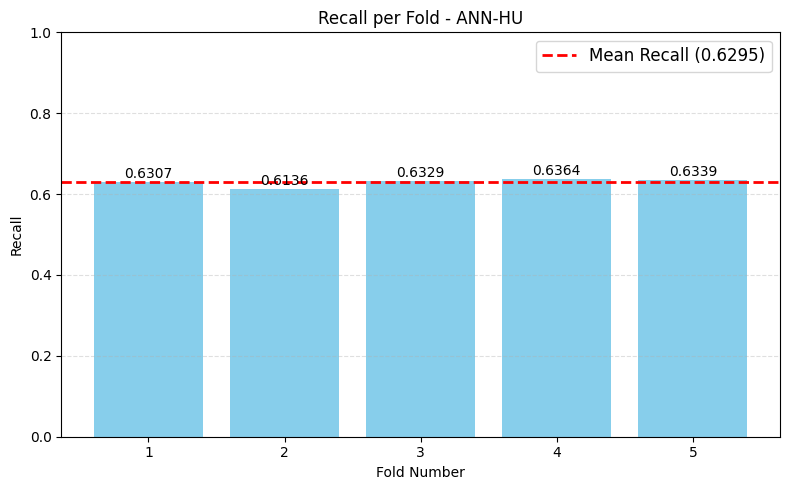

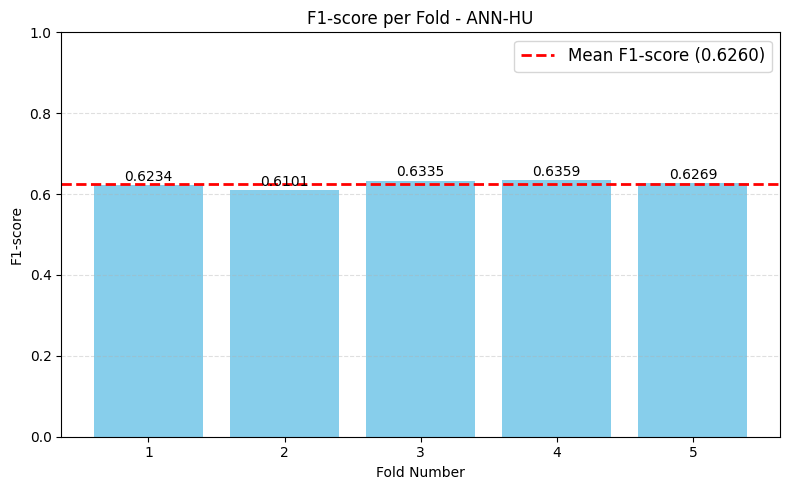


===== Cross-Validation Summary (Macro Averaged) — ANN-HU =====
Mean Accuracy : 0.6289
Mean Precision: 0.6345
Mean Recall   : 0.6295
Mean F1-score : 0.6260


In [10]:
bar_chart_cv(acc_scores, "Accuracy",  "ANN-HU")
bar_chart_cv(prec_scores, "Precision", "ANN-HU")
bar_chart_cv(rec_scores,  "Recall",    "ANN-HU")
bar_chart_cv(f1_scores,   "F1-score",  "ANN-HU")

print_cv_summary(acc_scores, prec_scores, rec_scores, f1_scores, model_name="ANN-HU")


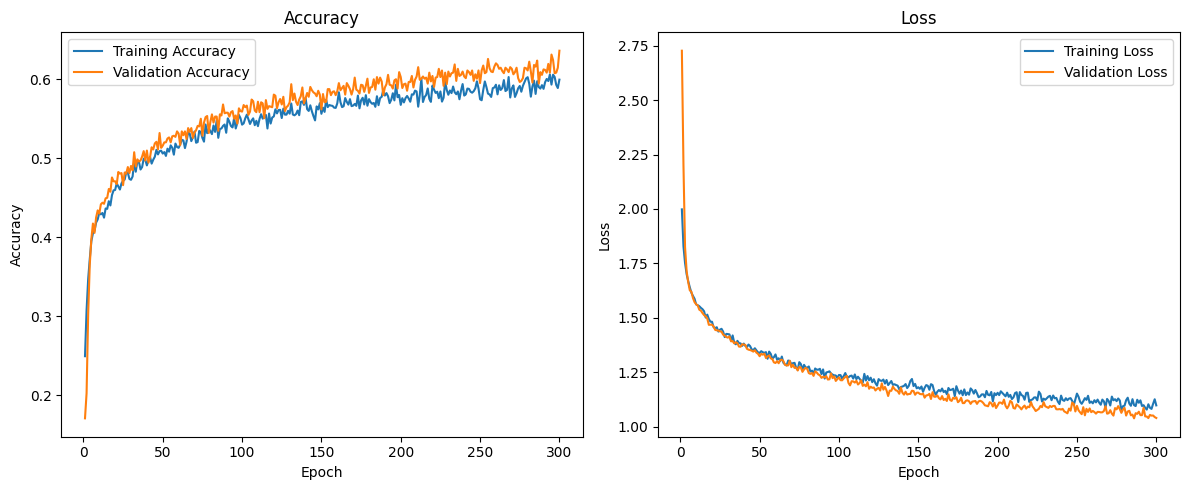

In [11]:
# Plot Accuracy & Loss for BEST fold
epochs_range = range(1, len(best_history.history['accuracy']) + 1)

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, best_history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, best_history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, best_history.history['loss'], label='Training Loss')
plt.plot(epochs_range, best_history.history['val_loss'], label='Validation Loss')
plt.title("Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


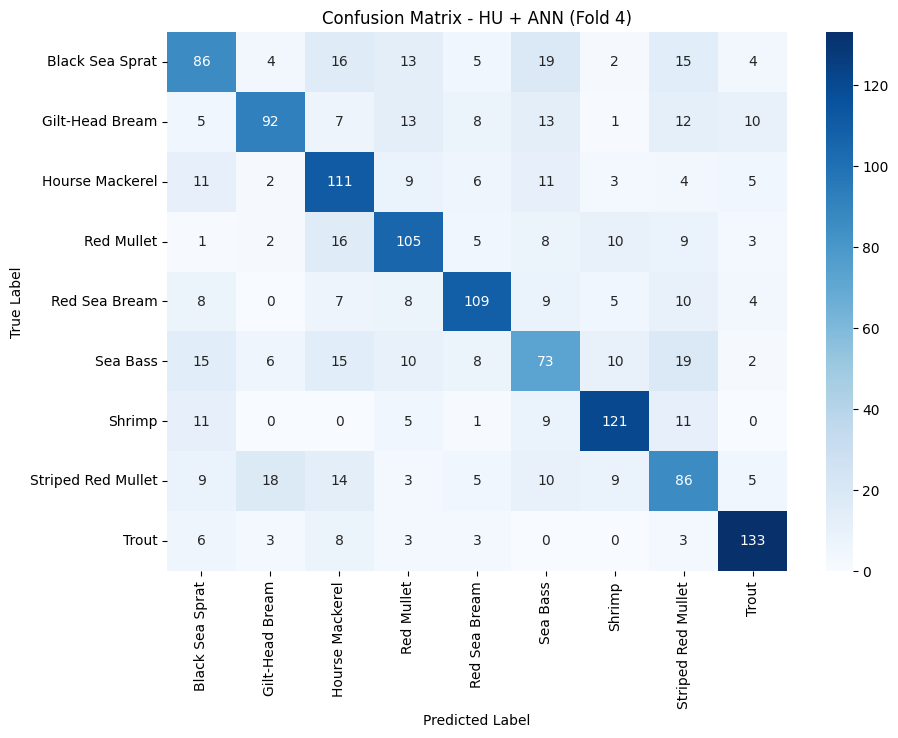

In [12]:
# Confusion Matrix for BEST fold
cm = confusion_matrix(best_y_val, best_y_val_pred)

# Plotting the confusion matrix using a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f"Confusion Matrix - HU + ANN (Fold {best_fold})")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## KNN with moments HU

In [12]:
def build_knn_hu():
    return KNeighborsClassifier(
        n_neighbors=3,
        metric='euclidean',
        weights='distance'
    )


print("\n===== 5-Fold Cross Validation — KNN + HU Moments =====")

y_labels_train = y_train
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

acc_scores = []
prec_scores = []
rec_scores = []
f1_scores = []

# Tracking the BEST fold
best_fold = None
best_val_acc = -np.inf
best_y_val = None
best_y_val_pred = None
best_model = None


for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_hu, y_labels_train), start=1):

    X_tr, X_val = X_train_hu[train_idx], X_train_hu[val_idx]
    y_tr, y_val = y_labels_train[train_idx], y_labels_train[val_idx]

    knn_cv = build_knn_hu()
    knn_cv.fit(X_tr, y_tr)

    y_val_pred = knn_cv.predict(X_val)

    acc = accuracy_score(y_val, y_val_pred)
    prec = precision_score(y_val, y_val_pred, average='macro')
    rec = recall_score(y_val, y_val_pred, average='macro')
    f1 = f1_score(y_val, y_val_pred, average='macro')

    acc_scores.append(acc)
    prec_scores.append(prec)
    rec_scores.append(rec)
    f1_scores.append(f1)

    print(f"\n--- Fold {fold} ---")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")

    # check if this is the best fold
    if acc > best_val_acc:
        best_val_acc = acc
        best_fold = fold
        best_y_val = y_val
        best_y_val_pred = y_val_pred
        best_model = knn_cv



===== 5-Fold Cross Validation — KNN + HU Moments =====

--- Fold 1 ---
Accuracy : 0.7750
Precision: 0.7740
Recall   : 0.7753
F1-score : 0.7738

--- Fold 2 ---
Accuracy : 0.7764
Precision: 0.7780
Recall   : 0.7770
F1-score : 0.7765

--- Fold 3 ---
Accuracy : 0.7757
Precision: 0.7760
Recall   : 0.7760
F1-score : 0.7750

--- Fold 4 ---
Accuracy : 0.7625
Precision: 0.7630
Recall   : 0.7628
F1-score : 0.7620

--- Fold 5 ---
Accuracy : 0.7708
Precision: 0.7700
Recall   : 0.7714
F1-score : 0.7689


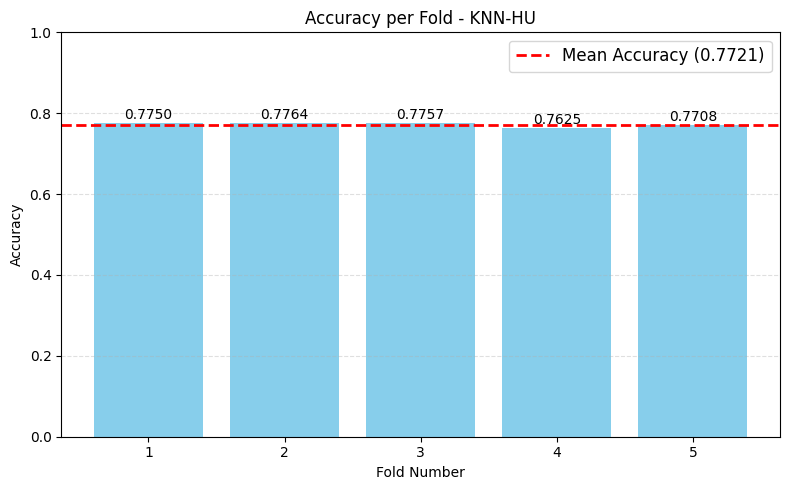

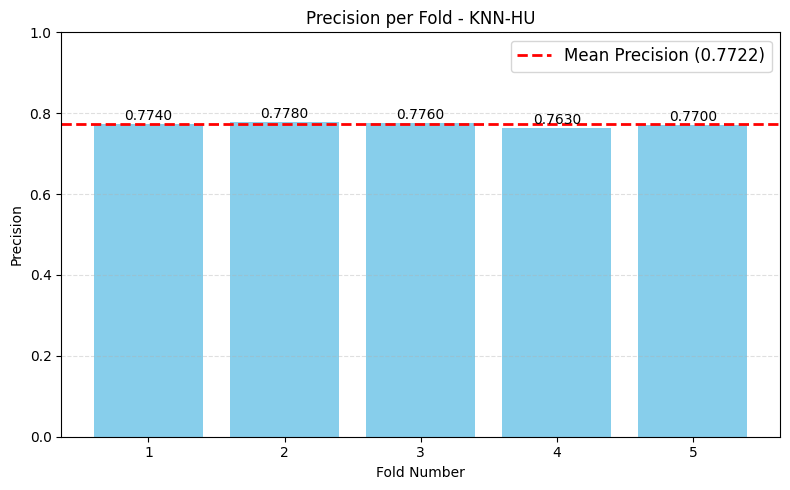

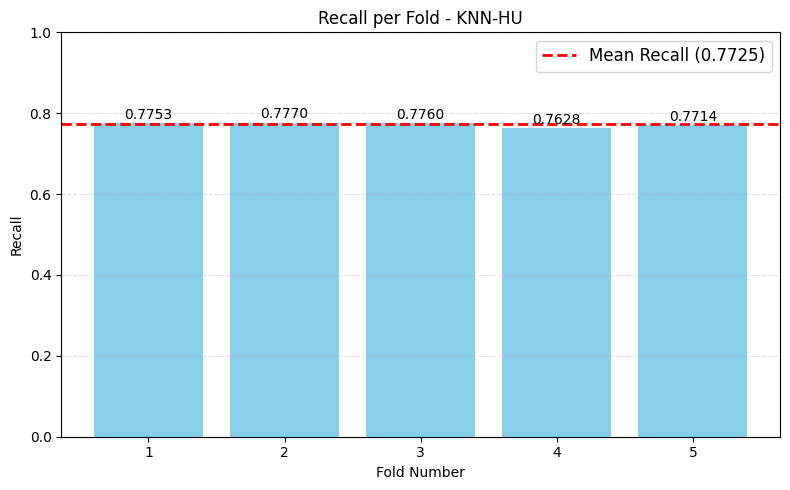

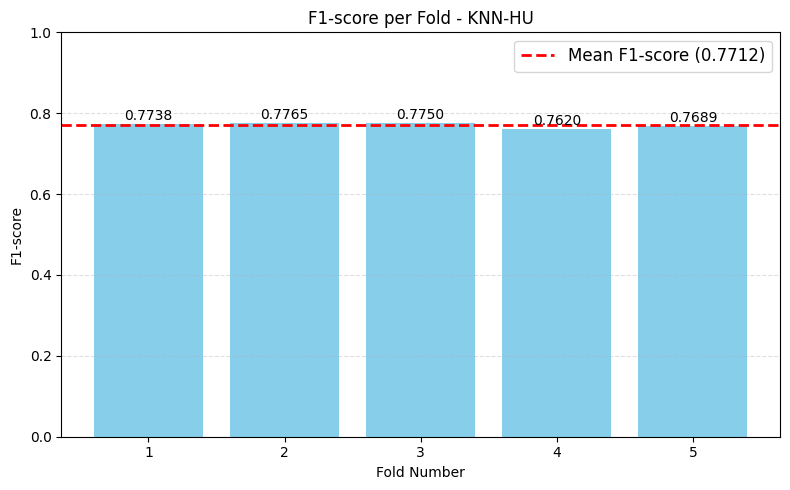


===== Cross-Validation Summary (Macro Averaged) — KNN-HU =====
Mean Accuracy : 0.7721
Mean Precision: 0.7722
Mean Recall   : 0.7725
Mean F1-score : 0.7712


In [13]:
bar_chart_cv(acc_scores, metric_name="Accuracy",  model_name="KNN-HU")
bar_chart_cv(prec_scores, metric_name="Precision", model_name="KNN-HU")
bar_chart_cv(rec_scores,  metric_name="Recall",    model_name="KNN-HU")
bar_chart_cv(f1_scores,   metric_name="F1-score",  model_name="KNN-HU")

print_cv_summary(acc_scores, prec_scores, rec_scores, f1_scores, model_name="KNN-HU")


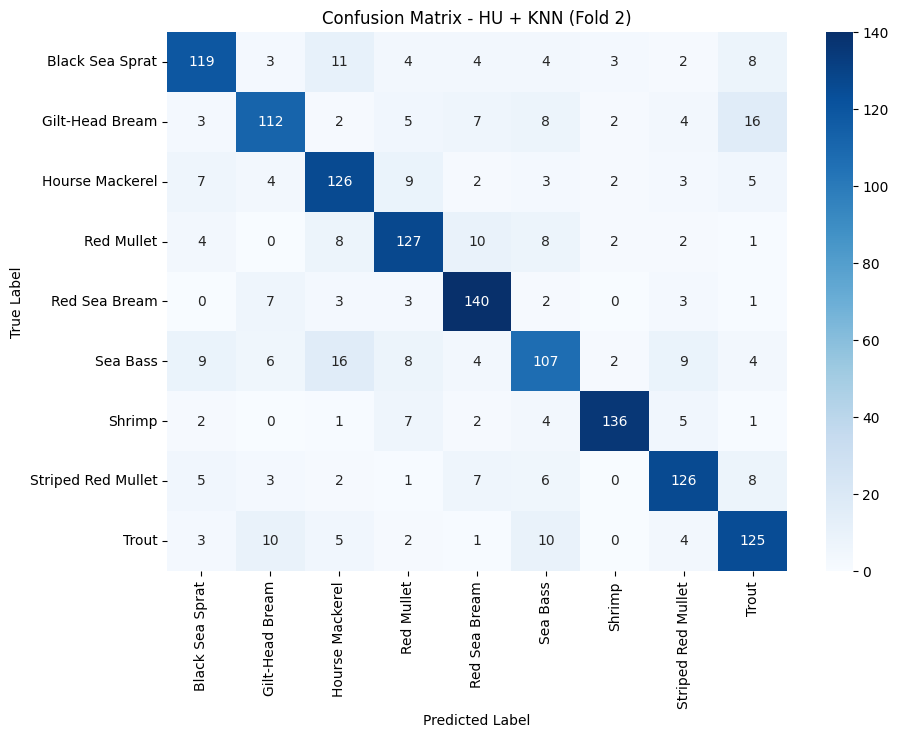

In [14]:
# Confusion Matrix for BEST fold
cm = confusion_matrix(best_y_val, best_y_val_pred)

# Plotting the confusion matrix using a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f"Confusion Matrix - HU + KNN (Fold {best_fold})")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## SVM

In [15]:
def build_svm_hu():
    return SVC(
        kernel='rbf',
        C=100,
        gamma=0.1,
        random_state=42
    )

print("\n===== 5-Fold Cross Validation — SVM + HU Moments =====")

y_labels_train = y_train  # already label-encoded
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

acc_scores = []
prec_scores = []
rec_scores = []
f1_scores = []

# Tracking the BEST fold
best_fold = None
best_val_acc = -np.inf
best_y_val = None
best_y_val_pred = None
best_model = None


for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_hu, y_labels_train), start=1):
    X_tr, X_val = X_train_hu[train_idx], X_train_hu[val_idx]
    y_tr, y_val = y_labels_train[train_idx], y_labels_train[val_idx]

    svm_cv = build_svm_hu()
    svm_cv.fit(X_tr, y_tr)

    y_val_pred = svm_cv.predict(X_val)

    acc = accuracy_score(y_val, y_val_pred)
    prec = precision_score(y_val, y_val_pred, average='macro')
    rec = recall_score(y_val, y_val_pred, average='macro')
    f1 = f1_score(y_val, y_val_pred, average='macro')

    acc_scores.append(acc)
    prec_scores.append(prec)
    rec_scores.append(rec)
    f1_scores.append(f1)

    print(f"\n--- Fold {fold} ---")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")

    # check if this is the best fold
    if acc > best_val_acc:
        best_val_acc = acc
        best_fold = fold
        best_y_val = y_val
        best_y_val_pred = y_val_pred
        best_model = svm_cv



===== 5-Fold Cross Validation — SVM + HU Moments =====

--- Fold 1 ---
Accuracy : 0.5479
Precision: 0.5541
Recall   : 0.5480
F1-score : 0.5473

--- Fold 2 ---
Accuracy : 0.5569
Precision: 0.5615
Recall   : 0.5578
F1-score : 0.5519

--- Fold 3 ---
Accuracy : 0.5493
Precision: 0.5590
Recall   : 0.5498
F1-score : 0.5469

--- Fold 4 ---
Accuracy : 0.5500
Precision: 0.5532
Recall   : 0.5507
F1-score : 0.5460

--- Fold 5 ---
Accuracy : 0.5507
Precision: 0.5579
Recall   : 0.5513
F1-score : 0.5456


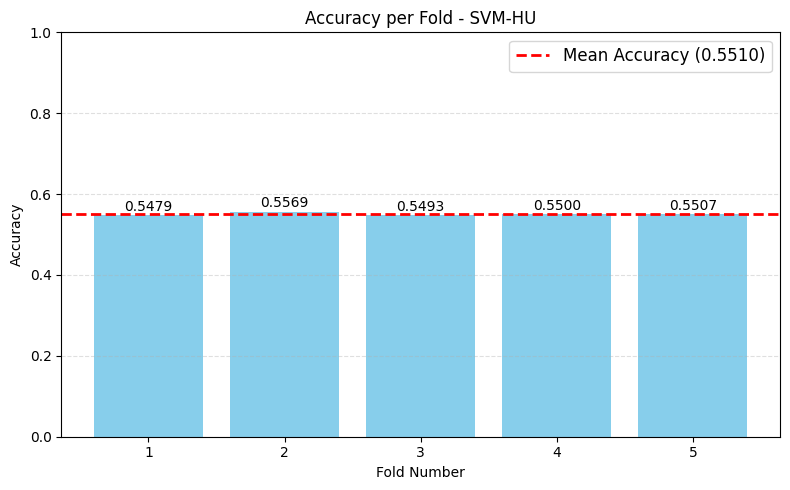

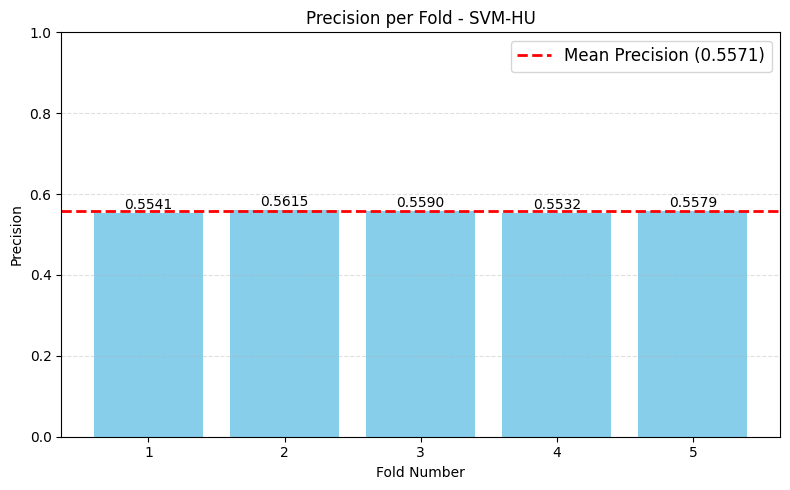

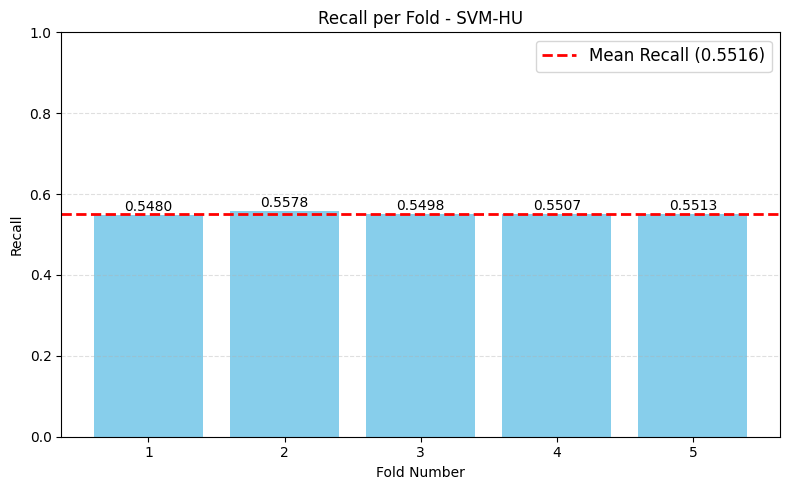

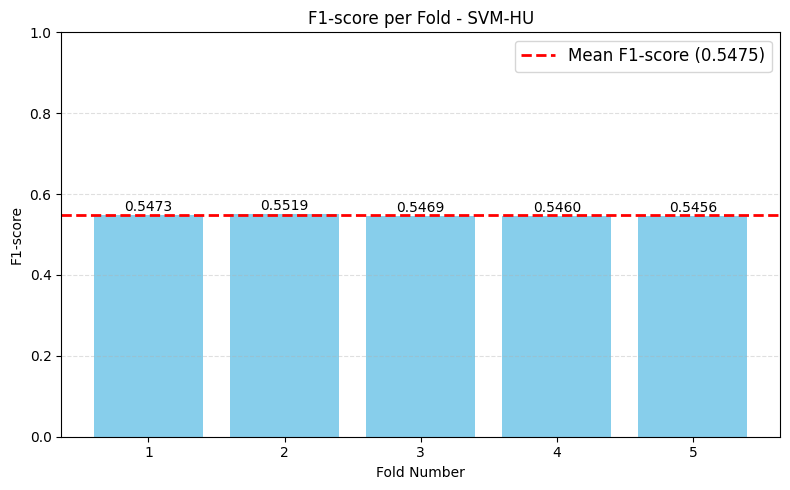


===== Cross-Validation Summary (Macro Averaged) — SVM-HU =====
Mean Accuracy : 0.5510
Mean Precision: 0.5571
Mean Recall   : 0.5516
Mean F1-score : 0.5475


In [16]:
bar_chart_cv(acc_scores, metric_name="Accuracy",  model_name="SVM-HU")
bar_chart_cv(prec_scores, metric_name="Precision", model_name="SVM-HU")
bar_chart_cv(rec_scores,  metric_name="Recall",    model_name="SVM-HU")
bar_chart_cv(f1_scores,   metric_name="F1-score",  model_name="SVM-HU")

print_cv_summary(acc_scores, prec_scores, rec_scores, f1_scores, model_name="SVM-HU")


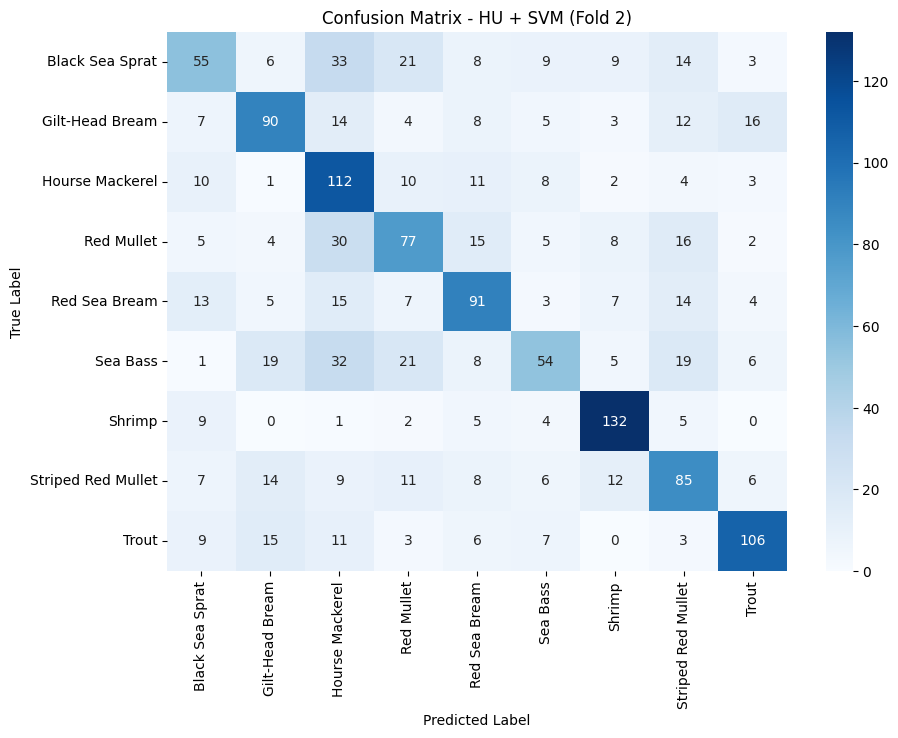

In [17]:
# Confusion Matrix for BEST fold
cm = confusion_matrix(best_y_val, best_y_val_pred)

# Plotting the confusion matrix using a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f"Confusion Matrix - HU + SVM (Fold {best_fold})")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()